In [1]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
from torchinfo import summary
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py

from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import DataLoader, TensorDataset

# Helper Classes
from App_Data_Processor import Data_Processor
from App_LSTM_Model import LSTM_Model

In [2]:
# Model & Learning Config
cfg_split         = 0.8
cfg_input_size    = 1
cfg_num_layers    = 4
cfg_hidden_size   = 50
cfg_dropout       = 0.1
cfg_learning_rate = 0.001
model             = LSTM_Model(input_size=cfg_input_size,
                               num_layers=cfg_num_layers,
                               hidden_size=cfg_hidden_size,
                               dropout=cfg_dropout,
                               learning_rate=cfg_learning_rate)

# Data Config
cfg_seq_len       = 90
cfg_data_date_fmt = "%Y-%m-%d"
cfg_data_url      = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"
data_processor    = Data_Processor(seq_length=cfg_seq_len)

# Trainer Config
cfg_batch_size  = 50
cfg_max_epochs  = 10
cfg_num_workers = 2

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "LSTM-Project"
cfg_logger_version = "v1.0.0"


In [3]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [4]:
# Load Data - Parse the Date Column
data_processor.load_data(url=cfg_data_url, date_fmt=cfg_data_date_fmt)

# Get Raw & Avg Sales Dataframes
df_sales_raw = data_processor.df_sales_raw
df_sales_avg = data_processor.df_sales_avg

# Scale the Dataframe
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales_data = scaler.fit_transform(data_processor.sales_raw)
scaled_sales_data_avg = scaler.fit_transform(data_processor.sales_avg)


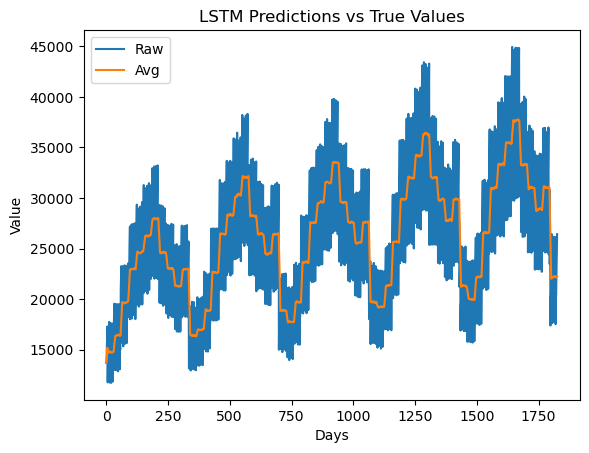

In [5]:
# Plot the true values and the predictions
plt.plot(df_sales_raw["sales"], label="Raw")
plt.plot(df_sales_avg["sales"], label="Avg")
plt.xlabel("Days")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()

In [6]:
# Preprocess the historical data
x, y = data_processor.create_sequences(scaled_sales_data_avg)

# Split the data into training and testing sets
train_size = int(len(y) * cfg_split)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()


In [7]:
summary(model, input_data=torch.Tensor(x_train[0:5]).float())

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Model                               [5, 1]                    --
├─LSTM: 1-1                              [5, 90, 50]               71,800
├─Linear: 1-2                            [5, 1]                    51
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 32.31
Input size (MB): 0.50
Forward/backward pass size (MB): 0.18
Params size (MB): 0.29
Estimated Total Size (MB): 0.97

In [8]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train).float(),
                                                torch.Tensor(y_train).float())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_test).float(), 
                                              torch.Tensor(y_test).float())), 
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)


logger = pl.loggers.CSVLogger("lstm-logger", 
                              name="LSTM-Project",
                              version="1.0.0")

In [9]:
trainer = pl.Trainer(logger=logger, 
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning:

Experiment logs directory lstm-logger/LSTM-Project/1.0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.34827712178230286    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.34827712178230286}]

In [11]:
trainer.fit(model, xy_train, xy_val) 


  | Name | Type    | Params
---------------------------------
0 | lstm | LSTM    | 71.8 K
1 | fc   | Linear  | 51    
2 | loss | MSELoss | 0     
---------------------------------
71.9 K    Trainable params
0         Non-trainable params
71.9 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [12]:
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.004432558547705412    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.004432558547705412}]

In [13]:
torch.save(model.state_dict(), './lstm-model.pth')

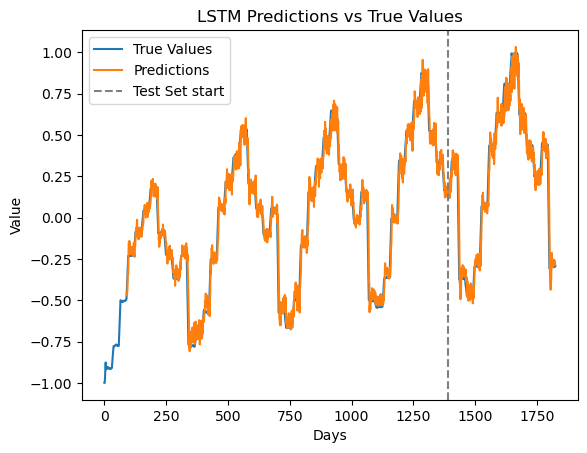

In [14]:
# Concatenate the training and test predictions
with torch.no_grad():
    train_outputs = model(x_train).squeeze().numpy()
    test_outputs = model(x_test).squeeze().numpy()
    
all_outputs = np.concatenate((train_outputs, test_outputs))

# Calculate the index where the test set starts
test_start_index = len(scaled_sales_data_avg) - len(y_test) - cfg_seq_len

# Plot the true values and the predictions
plt.plot(scaled_sales_data_avg, label="True Values")
plt.plot(range(cfg_seq_len, cfg_seq_len + len(all_outputs)), all_outputs, label="Predictions")
plt.axvline(x=test_start_index, color='gray', linestyle='--', label="Test Set start")
plt.xlabel("Days")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()